# House Prices

利用79個變數來預測在Iowa洲的住宅房價

# Feature Enginnering

In [84]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#
import math

# pandas
import pandas as pd

# numpy, matplotlb, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import scipy.stats as st

# statsmodels
import statsmodels.formula.api as sm

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Machine Learning
from sklearn.linear_model import LinearRegression

In [2]:
# Import dataset set
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## 檢視預測目標

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


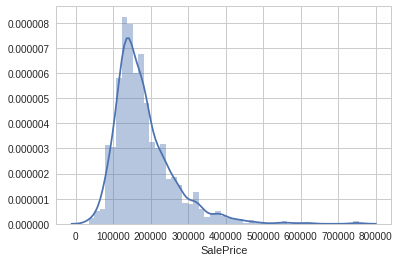

In [3]:
# Analysing dependent variable 'SalePrice'
sns.distplot(train['SalePrice'])
print(train['SalePrice'].describe())

* 偏移的normal distribution
* 正向skweness

## 分析預測目標與變數間的關係

In [4]:
missing = train.isnull().sum().sort_values(ascending=False)
print(missing.nlargest(10))

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
dtype: int64


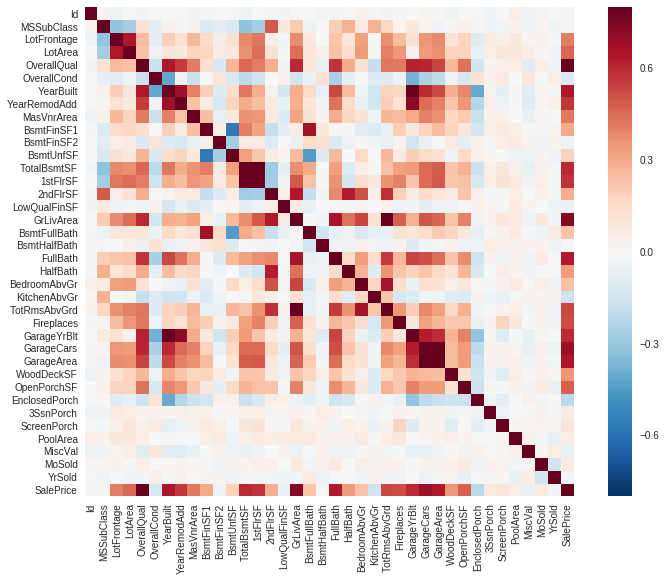

In [5]:
# Visiualize correlation matrix with heatmap
corrmat = train.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [163]:
# Top 10 correlation variables 
corrmat['SalePrice'].nlargest(10)

SalePrice       1.000000
OverallQual     0.791069
GrLivArea       0.708618
GarageArea      0.623423
1stFlrSF        0.605968
FullBath        0.560881
TotRmsAbvGrd    0.533779
YearBuilt       0.523273
YearRemodAdd    0.507430
Fireplaces      0.466968
Name: SalePrice, dtype: float64

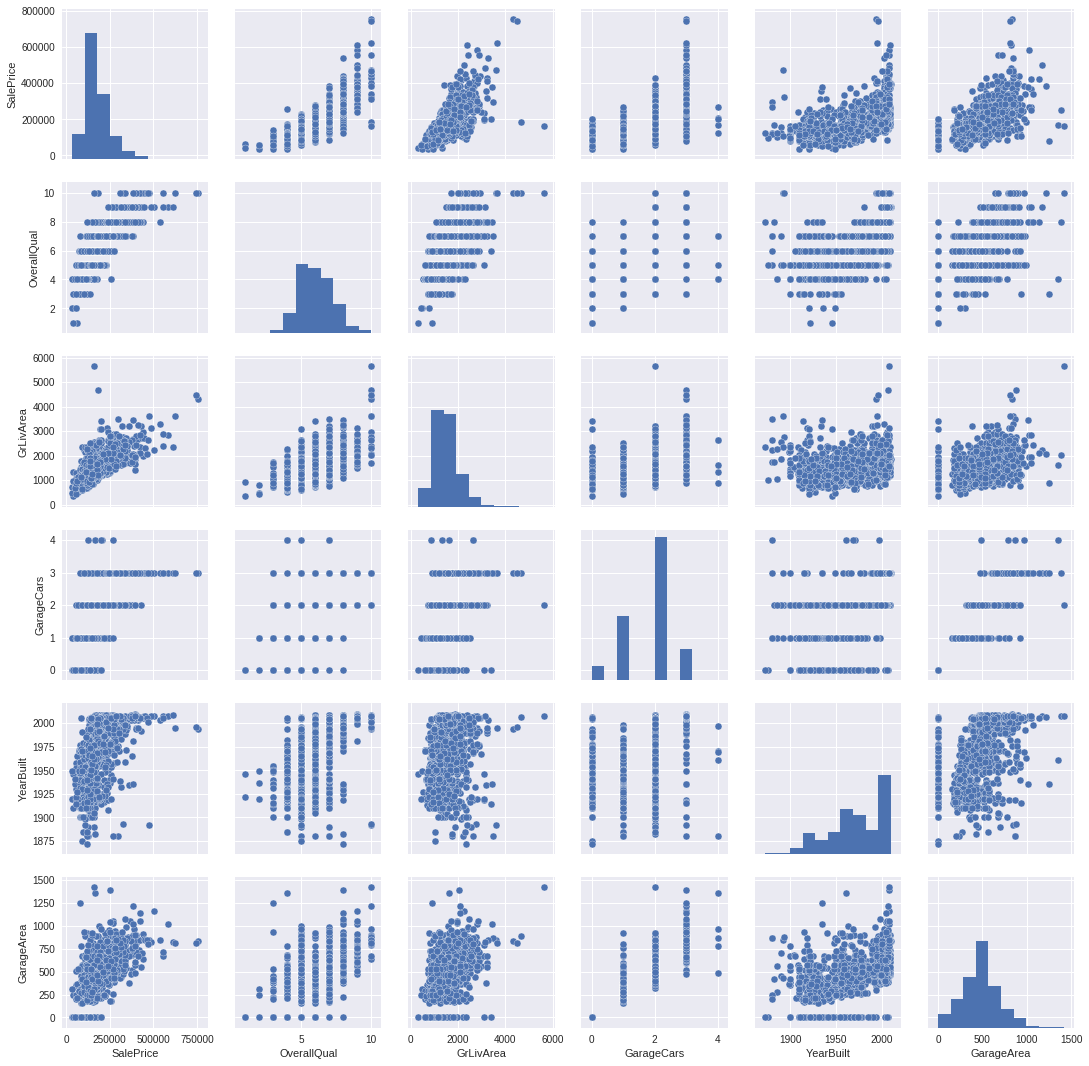

In [7]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'YearBuilt', 'GarageArea']
sns.pairplot(train[cols], size=2.5)
plt.show()

### 去除帶來重複資訊量的變數

In [8]:
# Relationship between variables
class variable_relationship():
    def __init__(self, df, y, axis=None):
        self.df = df
        self.y = y

    def relationship(self, x, plot, order=None, ymin=None, ymax=None):
        data = pd.concat([self.df[x], self.df[self.y]], axis = 1)
        if plot == 'scatter':
            data.plot.scatter(x=x, y=self.y, ylim=(ymin, ymax))
        elif plot == 'boxplot':
            f, ax = plt.subplots(figsize=(8, 6))
            fig = sns.boxplot(x=x, y=self.y, data=self.df, order=order)
            fig.axis(ymin=ymin, ymax=ymax)
        else:
            print('Missing Plot Type: {}'.format(plot))
SP = variable_relationship(train, 'SalePrice', axis=1)

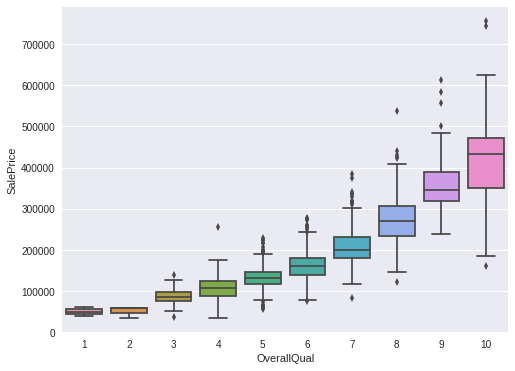

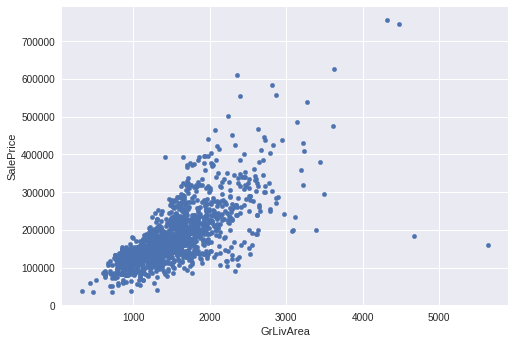

In [9]:
# OverallQual
SP.relationship('OverallQual', 'boxplot')
SP.relationship('GrLivArea', 'scatter')

整體上呈現良好的線性關係，之後處理完outliar預計會有更好的表現。

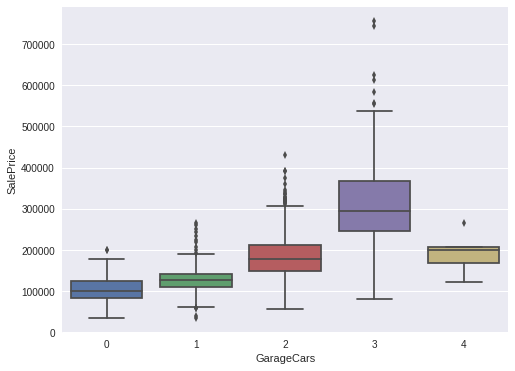

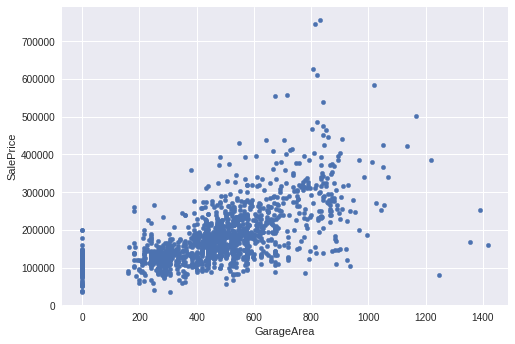

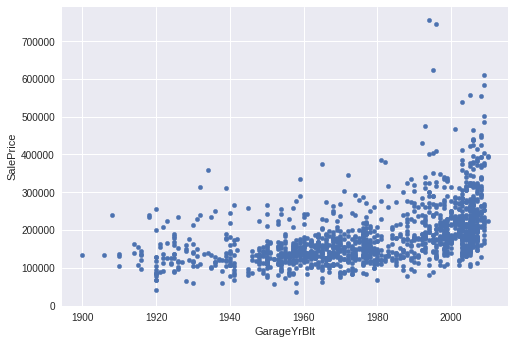

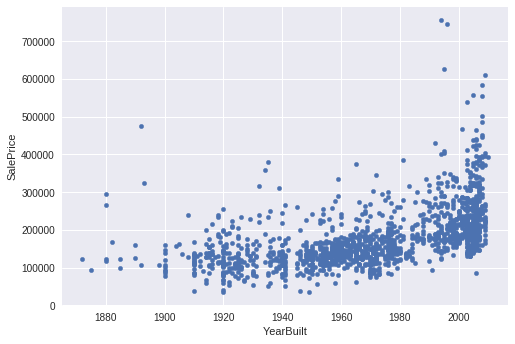

In [10]:
# GarageX
SP.relationship('GarageCars', 'boxplot')
SP.relationship('GarageArea', 'scatter')
SP.relationship('GarageYrBlt', 'scatter')
SP.relationship('YearBuilt', 'scatter')

* 雖然GarageCars的相關係數在這三者中比較高，但從資料可以看出其在數字4的時候有明顯的掉落， 相較之下 GarageArea 在拿掉outlier後會呈現更好的線性關係，保留GarageArea。
* 而GarageYrBlt與YearBuilt明顯相關，而在購買房屋時YearBuilt顯得比較有關係，保留YearBuilt。

In [11]:
corrmat['1stFlrSF'].nlargest(10)

1stFlrSF       1.000000
TotalBsmtSF    0.829292
SalePrice      0.575408
GrLivArea      0.494421
GarageArea     0.489797
GarageCars     0.450580
LotArea        0.443858
LotFrontage    0.427678
OverallQual    0.408730
Fireplaces     0.394883
Name: 1stFlrSF, dtype: float64

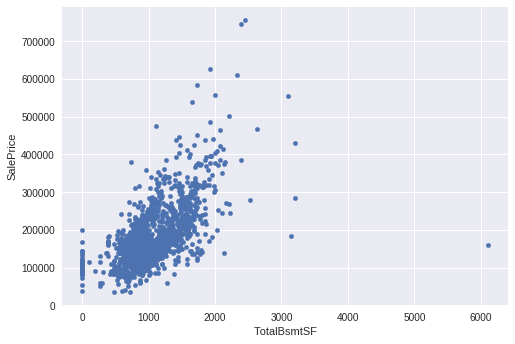

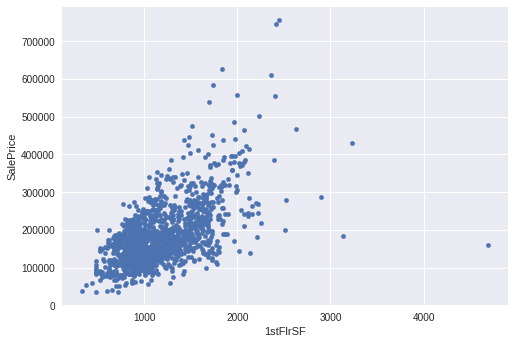

In [12]:
SP.relationship('TotalBsmtSF', 'scatter')
SP.relationship('1stFlrSF', 'scatter')

TotalBsmtSF與1stFlrSF 明顯相關，由於地下室有有無之分而一樓無，存在擾亂線性的0值，因此保留1stFlrSF

In [13]:
corrmat['FullBath'].nlargest(10)

FullBath        1.000000
GrLivArea       0.658419
SalePrice       0.635957
OverallQual     0.576372
TotRmsAbvGrd    0.558665
GarageYrBlt     0.538796
YearBuilt       0.537420
GarageCars      0.518310
GarageArea      0.444459
YearRemodAdd    0.431390
Name: FullBath, dtype: float64

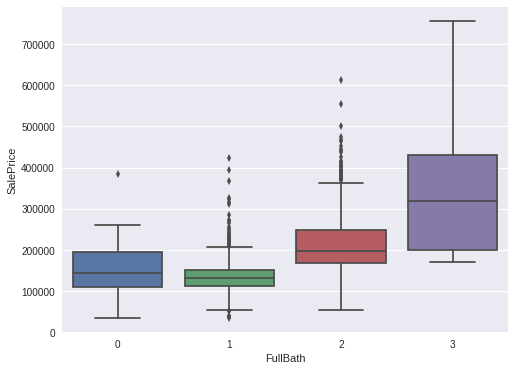

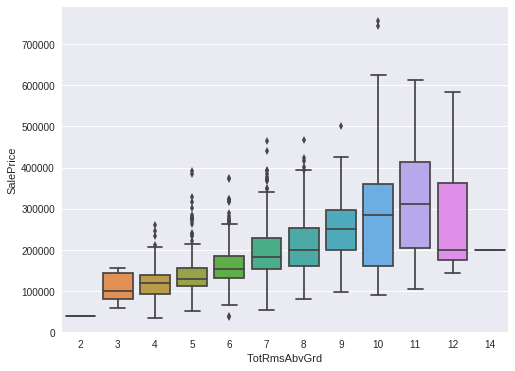

In [14]:
SP.relationship('FullBath', 'boxplot')
SP.relationship('TotRmsAbvGrd', 'boxplot')

FullBath與TotRmsAbvGrd原先設想會有很強的相關，但相關係數並沒有非常高，且有明顯線性關係，因此保留。

In [15]:
train = train.drop(['GarageCars', 'GarageYrBlt', 'TotalBsmtSF'], axis=1)

## 處理遺失資料

In [16]:
def missing_data(df):
    missing = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([missing, percent], axis=1, keys=['Missing', 'Percent'])
    print(missing_data.head(20))
    return missing_data
missing_train = missing_data(train)

              Missing   Percent
PoolQC           1453  0.995205
MiscFeature      1406  0.963014
Alley            1369  0.937671
Fence            1179  0.807534
FireplaceQu       690  0.472603
LotFrontage       259  0.177397
GarageFinish       81  0.055479
GarageType         81  0.055479
GarageCond         81  0.055479
GarageQual         81  0.055479
BsmtFinType2       38  0.026027
BsmtExposure       38  0.026027
BsmtFinType1       37  0.025342
BsmtQual           37  0.025342
BsmtCond           37  0.025342
MasVnrArea          8  0.005479
MasVnrType          8  0.005479
Electrical          1  0.000685
Exterior2nd         0  0.000000
YearBuilt           0  0.000000


* PoolQC, MiscFeature, Alley, Fence丟失超過80％的資料，而以上資料很可能存在於outlier之中，整欄丟棄。
* FireplaceQu將近一半遺失，且分佈顯示出有許多outliar，整欄丟棄。
* LotFrontage並無足夠強的線性關係與相關性，整攔丟棄。
* Garage與Bsmt系列個別的變數資料遺失數目相同或相近，由於在先前得知有與房價更高的Garage/Bsmt相關變數，整欄丟棄。
* MasVnr有太多0干擾，並無呈現足夠強的線性關係，整攔丟棄
* Electrical遺失數量很小，丟棄該筆資料。

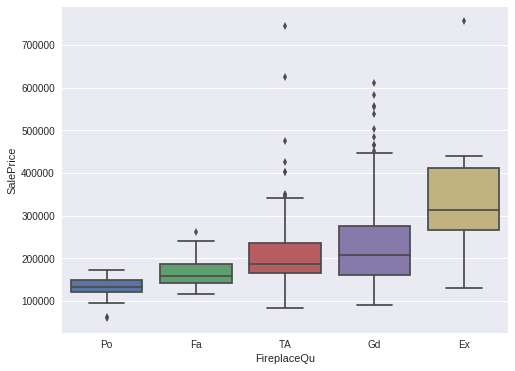

In [17]:
SP.relationship('FireplaceQu', 'boxplot', order=['Po','Fa', 'TA', 'Gd', 'Ex'])

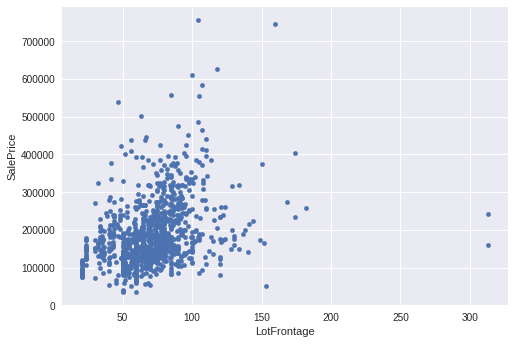

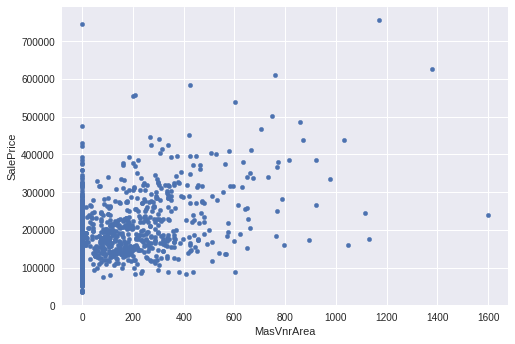

In [18]:
SP.relationship('LotFrontage', 'scatter')
SP.relationship('MasVnrArea', 'scatter')

In [19]:
# Drop columns in training set
train = train.drop((missing_train[missing_train['Missing'] > 1]).index, axis=1)
train = train.drop(train.loc[train['Electrical'].isnull()].index)
train.isnull().sum().max()

0

## 處理Outlier

### Univariate Analysis

In [20]:
saleprice_scaled = StandardScaler().fit_transform(train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[ 3.82758058]
 [ 4.0395221 ]
 [ 4.49473628]
 [ 4.70872962]
 [ 4.728631  ]
 [ 5.06034585]
 [ 5.42191907]
 [ 5.58987866]
 [ 7.10041987]
 [ 7.22629831]]


/home/lafes/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


### Bivariate Analysis

In [21]:
corrmat = train.corr()
corrmat['SalePrice'].nlargest(10)

SalePrice       1.000000
OverallQual     0.791069
GrLivArea       0.708618
GarageArea      0.623423
1stFlrSF        0.605968
FullBath        0.560881
TotRmsAbvGrd    0.533779
YearBuilt       0.523273
YearRemodAdd    0.507430
Fireplaces      0.466968
Name: SalePrice, dtype: float64

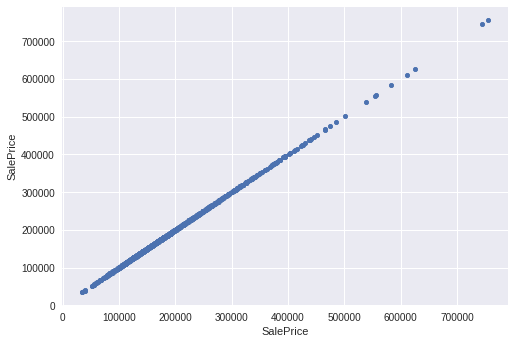

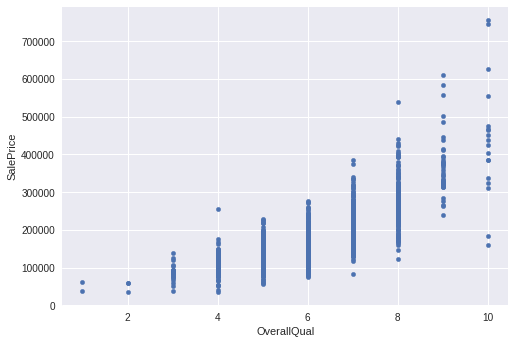

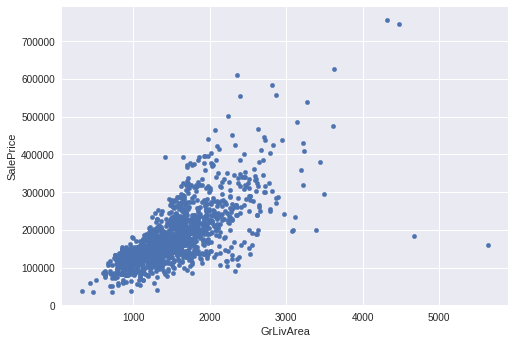

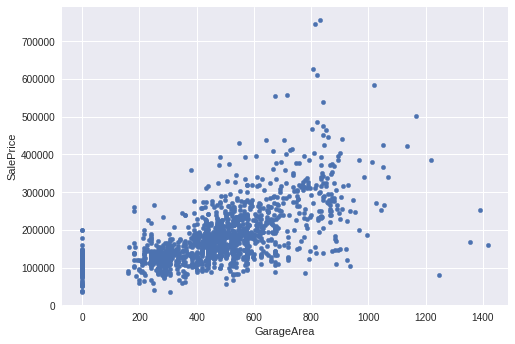

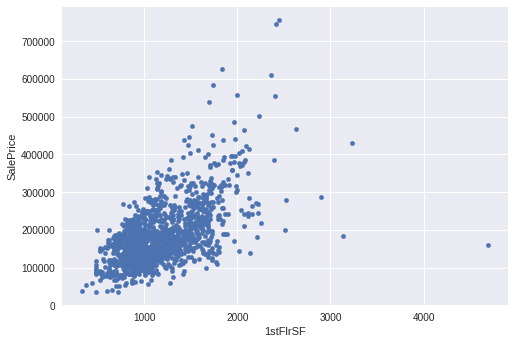

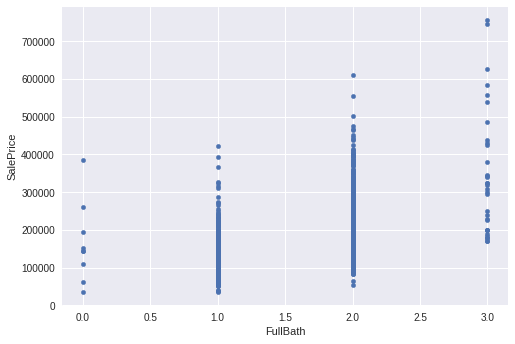

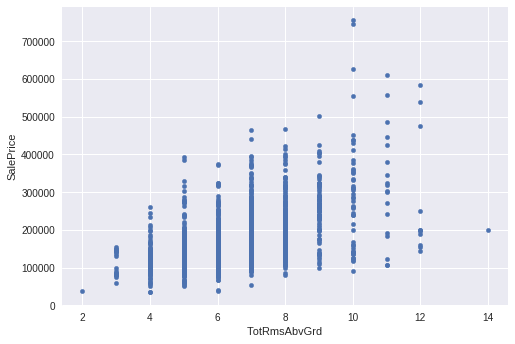

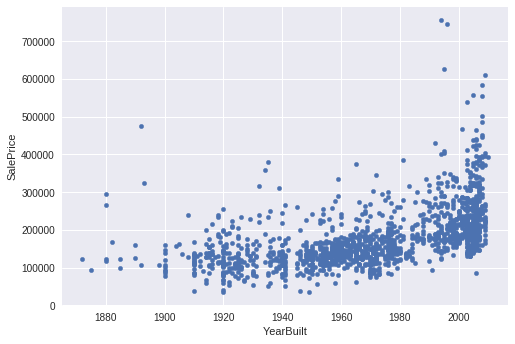

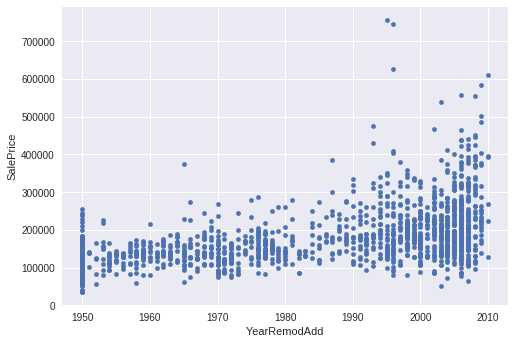

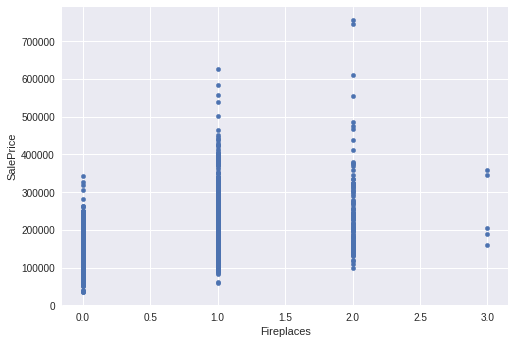

In [22]:
for col in corrmat['SalePrice'].nlargest(10).index.tolist():
    SP.relationship(col, 'scatter')

In [23]:
train.sort_values(by = 'GrLivArea', ascending = False)[:2]
train = train.drop(train[train['Id'] == 1299].index)
train = train.drop(train[train['Id'] == 524].index)

In [24]:
train.sort_values(by = 'GarageArea', ascending = False)[:4]
train = train.drop(train[train['Id'] == 582].index)
train = train.drop(train[train['Id'] == 1191].index)
train = train.drop(train[train['Id'] == 1062].index)
train = train.drop(train[train['Id'] == 826].index)

In [25]:
train.sort_values(by = 'TotRmsAbvGrd', ascending = False)[:1]
train = train.drop(train[train['Id'] == 636].index)

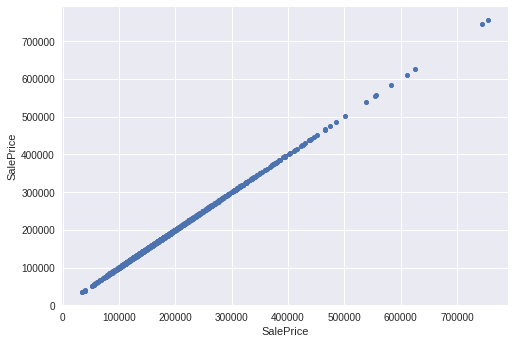

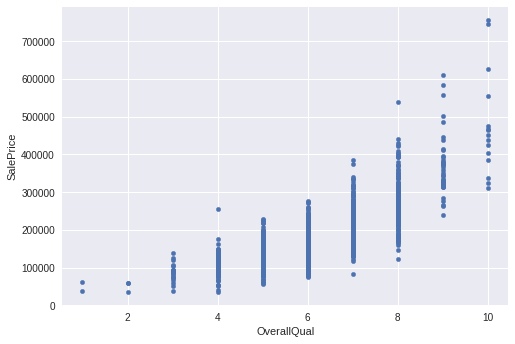

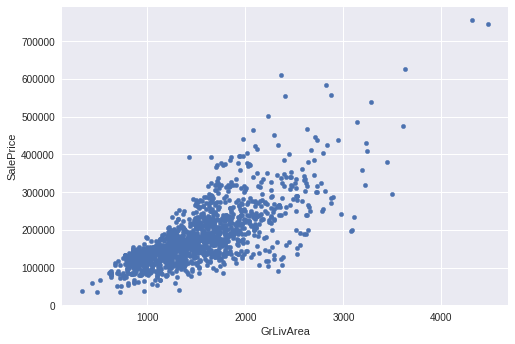

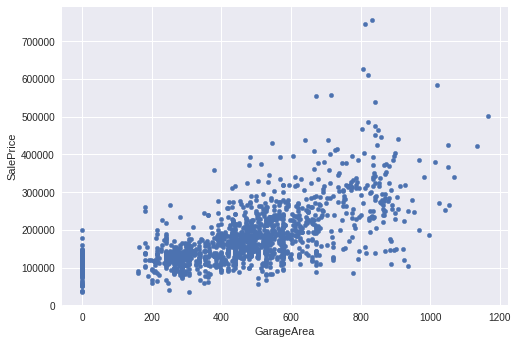

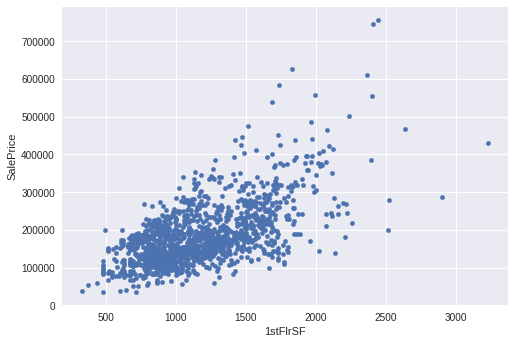

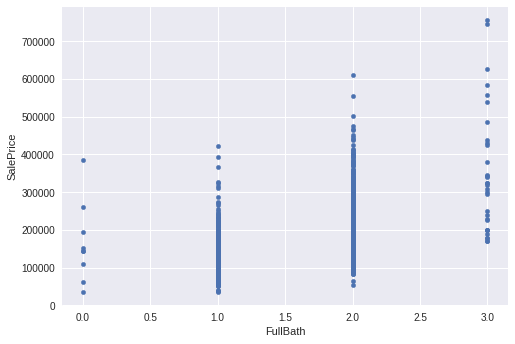

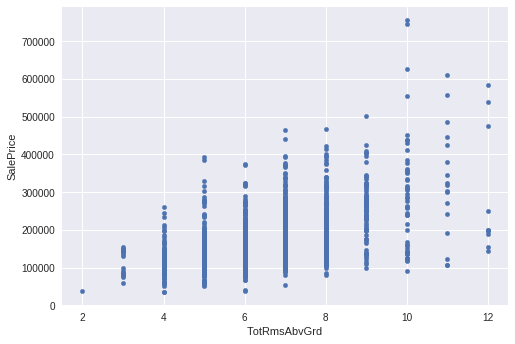

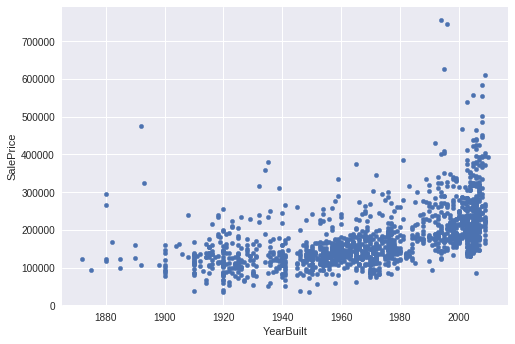

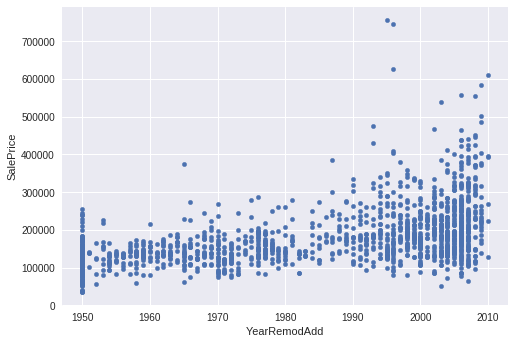

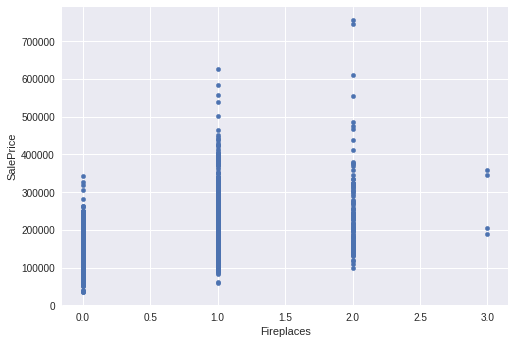

In [26]:
SP = variable_relationship(train, 'SalePrice', axis=1)
for col in corrmat['SalePrice'].nlargest(10).index.tolist():
    SP.relationship(col, 'scatter')

## Normality
資料成normal distribution可以適用於大部分的統計檢驗。

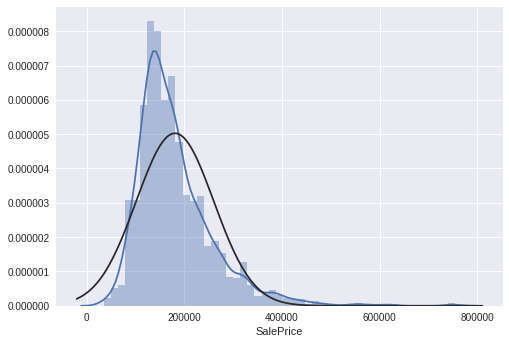

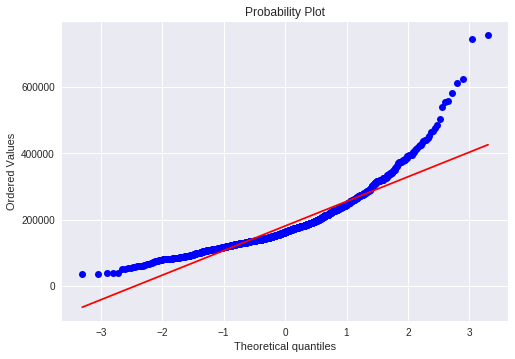

In [27]:
def normality(data):
    sns.distplot(data, fit=st.norm)
    fig = plt.figure()
    res = st.probplot(data, plot=plt)
normality(train['SalePrice'])

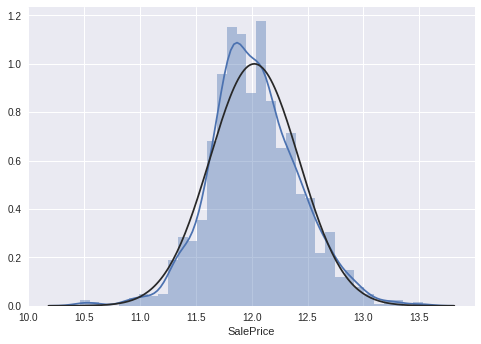

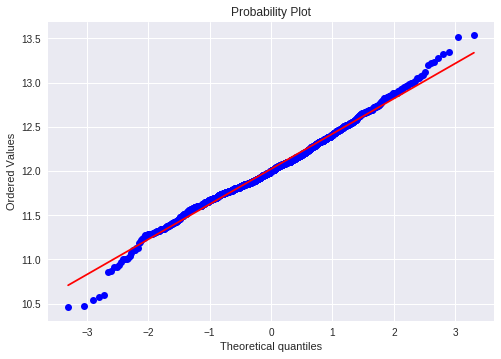

In [28]:
train['SalePrice'] = np.log(train['SalePrice'])
normality(train['SalePrice'])

In [29]:
# GrLivArea
train['GrLivArea'] = np.log(train['GrLivArea'])

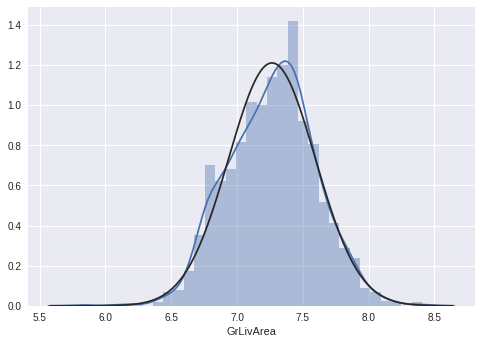

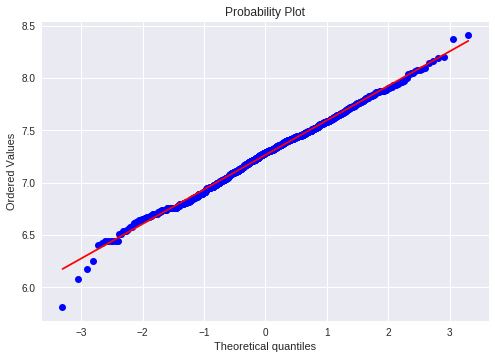

In [30]:
normality(train['GrLivArea'])

In [31]:
# 1stFlrSF
train['1stFlrSF'] = np.log(train['1stFlrSF'])

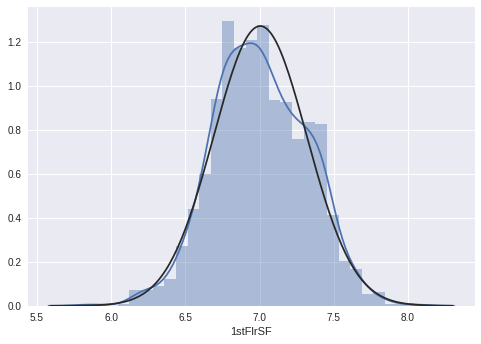

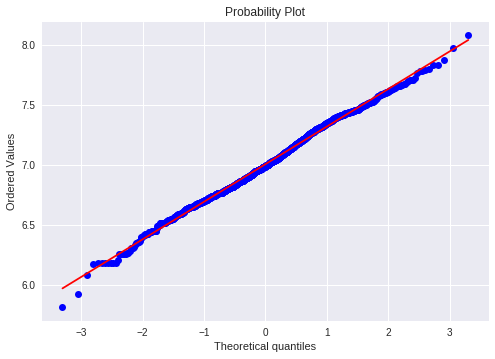

In [32]:
normality(train['1stFlrSF'])

In [33]:
corrmat['SalePrice'].nlargest(10)

SalePrice       1.000000
OverallQual     0.791069
GrLivArea       0.708618
GarageArea      0.623423
1stFlrSF        0.605968
FullBath        0.560881
TotRmsAbvGrd    0.533779
YearBuilt       0.523273
YearRemodAdd    0.507430
Fireplaces      0.466968
Name: SalePrice, dtype: float64

## 處理 Test set

In [34]:
# Drop same columns in test set
redundent_col = set(test.keys().tolist()) - set(train.keys().tolist())
test = test.drop(list(redundent_col), axis=1)
missing_test = missing_data(test)
missing_cols = missing_test.loc[missing_test['Missing']>0].index.tolist()
print(missing_cols)

               Missing   Percent
MSZoning             4  0.002742
BsmtHalfBath         2  0.001371
Utilities            2  0.001371
BsmtFullBath         2  0.001371
Functional           2  0.001371
KitchenQual          1  0.000685
GarageArea           1  0.000685
BsmtFinSF1           1  0.000685
Exterior2nd          1  0.000685
SaleType             1  0.000685
BsmtUnfSF            1  0.000685
BsmtFinSF2           1  0.000685
Exterior1st          1  0.000685
OverallCond          0  0.000000
RoofMatl             0  0.000000
RoofStyle            0  0.000000
ExterQual            0  0.000000
YearRemodAdd         0  0.000000
YearBuilt            0  0.000000
SaleCondition        0  0.000000
['MSZoning', 'BsmtHalfBath', 'Utilities', 'BsmtFullBath', 'Functional', 'KitchenQual', 'GarageArea', 'BsmtFinSF1', 'Exterior2nd', 'SaleType', 'BsmtUnfSF', 'BsmtFinSF2', 'Exterior1st']


In [35]:
test['MSZoning'].fillna('RL',inplace=True)
test['BsmtHalfBath'].fillna(0, inplace=True)
test['Utilities'].fillna('AllPub', inplace=True)
test['BsmtFullBath'].fillna(0, inplace=True)
test['Functional'].fillna('Typ', inplace=True)
test['KitchenQual'].fillna('TA', inplace=True)
test['GarageArea'].fillna(test['GarageArea'].mean(), inplace=True)
test['BsmtFinSF1'].fillna(test['BsmtFinSF1'].mean(), inplace=True)
test['Exterior2nd'].fillna('VinylSd', inplace=True)
test['SaleType'].fillna('WD', inplace=True)
test['BsmtUnfSF'].fillna(test['BsmtUnfSF'].mean(), inplace=True)
test['BsmtFinSF2'].fillna(0, inplace=True)
test['Exterior1st'].fillna('Wd Sdng', inplace=True)

由於遺失數量都很小，填補不會造成太大影響，目的只要讓缺失消失就行。

In [36]:
test.isnull().sum().max()

0